In [1]:
# =========================================================
# PHASE 4 — MODEL TRAINING & EVALUATION (FINAL)
# =========================================================
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from math import sqrt
import joblib, json, os

# --- Paths ---
ROOT = Path(r"C:\DOCTORAL HUB\nmr_pipeline_project")
DATA = ROOT / "data" / "merged"
RESULTS = ROOT / "results"
RESULTS.mkdir(parents=True, exist_ok=True)

# --- Load dataset ---
clean_file = DATA / "merged_phase3_clean.csv"
df = pd.read_csv(clean_file)
print(f" Loaded: {clean_file}")
print(f" Rows: {len(df):,} | Molecules: {df['mol_idx'].nunique():,}")
print(" Columns sample:", df.columns.tolist()[:10])


 Loaded: C:\DOCTORAL HUB\nmr_pipeline_project\data\merged\merged_phase3_clean.csv
 Rows: 434,147 | Molecules: 49,761
 Columns sample: ['mol_idx', 'atom_index', 'element_x', 'shift_ppm_x', 'element_y', 'shift_ppm_y', 'hose_1', 'hose_2', 'hose_3', 'hose_4']


In [2]:
# =========================================================
# Identify numeric descriptor columns and target column
# =========================================================
non_features = [
    "mol_idx", "atom_index", "element", "nucleus",
    "shift", "shift_ppm", "shift_ppm_x", "shift_ppm_y"
]

feature_cols = [
    c for c in df.columns
    if c not in non_features
    and np.issubdtype(df[c].dtype, np.number)
    and not c.lower().startswith("shift")
]

print(f" Using {len(feature_cols)} descriptor columns")

#  Use the correct target column (usually experimental shift)
target_col = "shift_ppm_y"
if target_col not in df.columns:
    raise KeyError(f"Target column '{target_col}' not found in dataset!")

X = df[feature_cols].values
y = df[target_col].values

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f" Train: {len(X_train):,} | Test: {len(X_test):,}")

# --- Feature scaling for linear models ---
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


 Using 128 descriptor columns
 Train: 347,317 | Test: 86,830


In [3]:
# =========================================================
# Helper to evaluate model performance
# =========================================================
def evaluate(model, X_train, X_test, y_train, y_test, label):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    try:
        rmse = mean_squared_error(y_test, y_pred, squared=False)
    except TypeError:
        rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f"\n {label}")
    print(f"R²: {r2:.4f} | RMSE: {rmse:.3f} | MAE: {mae:.3f}")
    return {"Model": label, "R2": r2, "RMSE": rmse, "MAE": mae, "y_pred": y_pred}


In [4]:
# =========================================================
# Train 3 baseline regressors
# =========================================================
results = []

# 1️ Linear Regression
lin = LinearRegression()
results.append(evaluate(lin, X_train, X_test, y_train, y_test, "Linear Regression"))

# 2️ Ridge Regression
ridge = Ridge(alpha=1.0, random_state=42)
results.append(evaluate(ridge, X_train, X_test, y_train, y_test, "Ridge Regression"))

# 3️ Random Forest Regression
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
results.append(evaluate(rf, X_train, X_test, y_train, y_test, "Random Forest"))



 Linear Regression
R²: 0.0781 | RMSE: 50.315 | MAE: 43.287

 Ridge Regression
R²: 0.0781 | RMSE: 50.315 | MAE: 43.287

 Random Forest
R²: 0.0857 | RMSE: 50.108 | MAE: 42.850


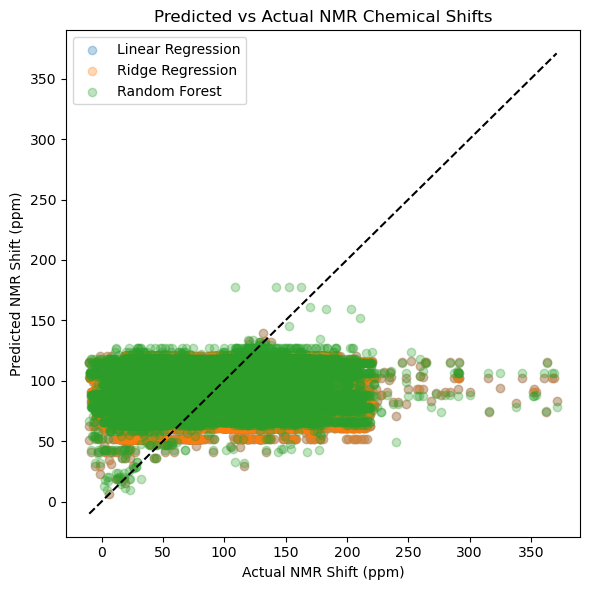

In [5]:
# =========================================================
# Predicted vs Actual Chemical Shifts
# =========================================================
plt.figure(figsize=(6,6))
for res in results:
    plt.scatter(y_test, res["y_pred"], alpha=0.3, label=res["Model"])
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--")
plt.xlabel("Actual NMR Shift (ppm)")
plt.ylabel("Predicted NMR Shift (ppm)")
plt.title("Predicted vs Actual NMR Chemical Shifts")
plt.legend()
plt.tight_layout()
plt.show()
